In [182]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

# PyTorch device CUDA0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [215]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [216]:
### Case 1: Homoskedastic noise

# Generate data

torch.manual_seed(42)
N = 100
x_lin = torch.linspace(-1, 1, N)

f = lambda x: 0.5 * x**2 + 0.25 * x**3

eps = torch.randn(N) * 0.2

y = f(x_lin) + eps

# Move to GPU
x_lin = x_lin.to(device)
y = y.to(device)


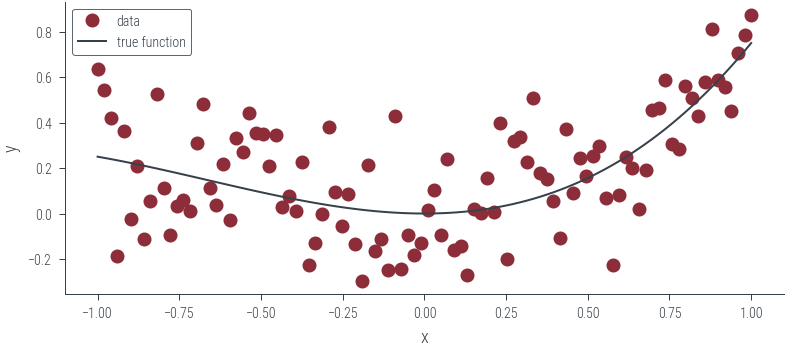

In [217]:
# Plot data and true function
plt.plot(x_lin.cpu(), y.cpu(), 'o', label='data')
plt.plot(x_lin.cpu(), f(x_lin).cpu(), label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [218]:
#### Case 1.1 NN with homoskedastic noise

class HomoskedasticNNFixedNoise(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        mu_hat = self.fc3(x)
        return mu_hat

In [219]:
def loss_homoskedastic_fixed_noise(model, x, y, log_noise_std):
    mu_hat = model(x).squeeze()
    assert mu_hat.shape == y.shape
    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).mean()


In [220]:
model_1 = HomoskedasticNNFixedNoise()
# Move to GPU
model_1.to(device)

HomoskedasticNNFixedNoise(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [221]:
fixed_log_noise_std = torch.log(torch.tensor(0.5)).to(device)
loss_homoskedastic_fixed_noise(model_1, x_lin[:, None], y, fixed_log_noise_std)

tensor(0.3774, device='cuda:0', grad_fn=<NegBackward0>)

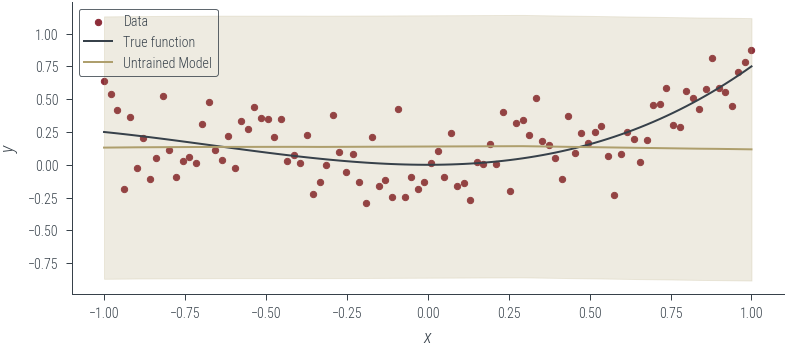

In [222]:
def plot_model_1(model, l="Untrained model", log_noise_param=fixed_log_noise_std):

    with torch.no_grad():
        y_hat = model(x_lin[:, None]).squeeze().cpu()
        std = torch.exp(log_noise_param).cpu()


    plt.scatter(x_lin.cpu(), y.cpu(), s=10, color='C0', label='Data')
    plt.plot(x_lin.cpu(), f(x_lin.cpu()), color='C1', label='True function')
    plt.plot(x_lin.cpu(), y_hat.cpu(), color='C2', label=l)
    # Plot the +- 2 sigma region (where sigma is fixed to 0.2)
    plt.fill_between(x_lin.cpu(), y_hat - 2 * std, y_hat + 2 * std, alpha=0.2, color='C2')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()

plot_model_1(model_1, "Untrained Model")


In [223]:
def train(model, loss_func, params, x, y, log_noise_param, n_epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(params, lr=lr)
    for epoch in range(n_epochs):
        # Print every 10 epochs
        if epoch % 50 == 0:
            noise_std = torch.exp(log_noise_param)  # Calculate the noise standard deviation
            print(f'Epoch {epoch}: loss {loss_func(model, x, y, log_noise_param)}')
        optimizer.zero_grad()
        loss = loss_func(model, x, y, log_noise_param)
        loss.backward()
        optimizer.step()
    return loss.item()


In [224]:
params = list(model_1.parameters())
train(model_1, loss_homoskedastic_fixed_noise, params, x_lin[:, None], y, fixed_log_noise_std, n_epochs=1000, lr=0.001)

Epoch 0: loss 0.37737852334976196
Epoch 50: loss 0.36576324701309204
Epoch 100: loss 0.36115822196006775
Epoch 150: loss 0.35357466340065
Epoch 200: loss 0.3445783853530884
Epoch 250: loss 0.33561965823173523
Epoch 300: loss 0.3253604769706726
Epoch 350: loss 0.3168313503265381
Epoch 400: loss 0.3112250566482544
Epoch 450: loss 0.30827972292900085
Epoch 500: loss 0.30689162015914917
Epoch 550: loss 0.30621206760406494
Epoch 600: loss 0.3059086203575134
Epoch 650: loss 0.30568134784698486
Epoch 700: loss 0.3052031695842743
Epoch 750: loss 0.305046409368515
Epoch 800: loss 0.30500170588493347
Epoch 850: loss 0.3049851953983307
Epoch 900: loss 0.30497878789901733
Epoch 950: loss 0.3049766719341278


0.3049757182598114

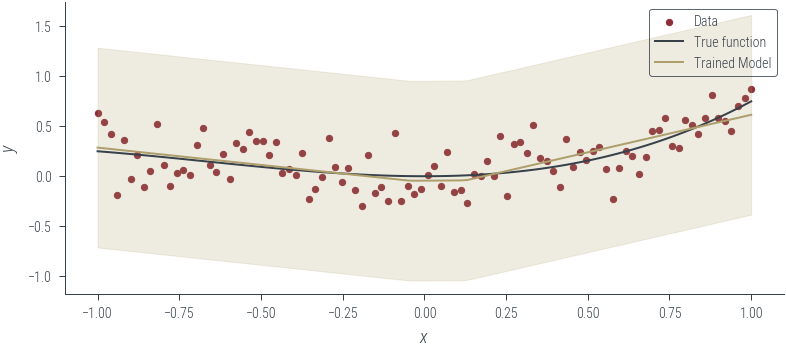

In [225]:
plot_model_1(model_1, "Trained Model")

#### Case 1.2  NN with homoskedastic noise (learned)

The model is the same as in case 1.1, but the noise is learned from the data. Thus, we need to modify the loss function to include the noise parameter $\sigma$.


In [226]:
# Define the loss function
def loss_homoskedastic_learned_noise(model, x, y, noise):
    mean = model(x)
    dist = torch.distributions.Normal(mean, noise)
    return -dist.log_prob(y).mean()

In [227]:
model_2 = HomoskedasticNNFixedNoise()
log_noise_param = torch.nn.Parameter(torch.tensor(0.0).to(device))

# Move to GPU
model_2.to(device)

HomoskedasticNNFixedNoise(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

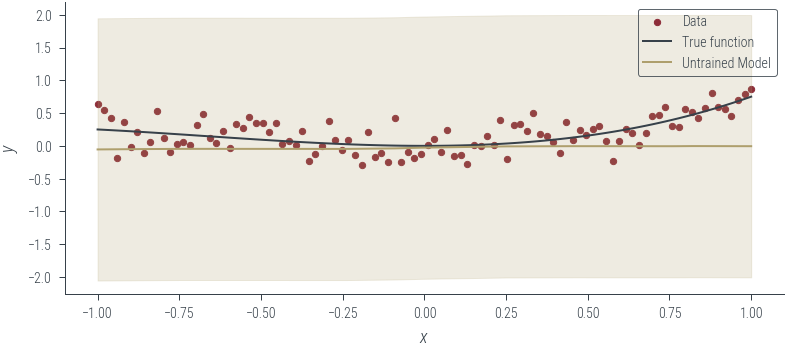

In [228]:
# Plot the untrained model
plot_model_1(model_2, "Untrained Model", log_noise_param=log_noise_param)

In [229]:
# Train the model
params = list(model_2.parameters()) + [log_noise_param]

train(model_2, loss_homoskedastic_fixed_noise, params, x_lin[:, None], y, log_noise_param, n_epochs=1000, lr=0.01)

Epoch 0: loss 0.9752065539360046
Epoch 50: loss 0.4708317220211029
Epoch 100: loss 0.06903044134378433
Epoch 150: loss -0.19027572870254517
Epoch 200: loss -0.31068307161331177
Epoch 250: loss -0.3400699496269226
Epoch 300: loss -0.3422872722148895
Epoch 350: loss -0.3424949049949646
Epoch 400: loss -0.3450787365436554
Epoch 450: loss -0.348661333322525
Epoch 500: loss -0.3499276638031006
Epoch 550: loss -0.34957197308540344
Epoch 600: loss -0.3541718125343323
Epoch 650: loss -0.3527887165546417
Epoch 700: loss -0.3585814833641052
Epoch 750: loss -0.3589327931404114
Epoch 800: loss -0.3592424690723419
Epoch 850: loss -0.3592303693294525
Epoch 900: loss -0.3538239300251007
Epoch 950: loss -0.35970067977905273


-0.3580436110496521

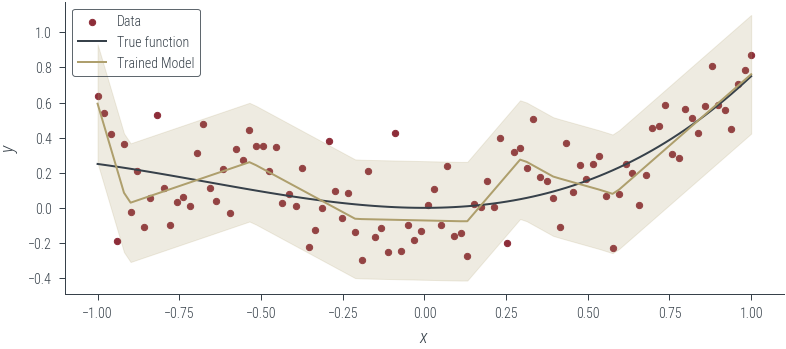

In [230]:
# Plot the trained model
plot_model_1(model_2, "Trained Model", log_noise_param=log_noise_param)

In [231]:
#### Heteroskedastic noise model

class HeteroskedasticNN(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, 2) # we learn both mu and log_noise_std
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        z = self.fc3(x)
        mu_hat = z[:, 0]
        log_noise_std = z[:, 1]
        return mu_hat, log_noise_std

In [232]:
model_3 = HeteroskedasticNN()
# Move to GPU
model_3.to(device)



AttributeError: 'tuple' object has no attribute 'squeeze'

In [239]:
def _plot(y_hat, std, l="Untrained model"):
    plt.scatter(x_lin.cpu(), y.cpu(), s=10, color='C0', label='Data')
    plt.plot(x_lin.cpu(), f(x_lin.cpu()), color='C1', label='True function')
    plt.plot(x_lin.cpu(), y_hat.cpu(), color='C2', label=l)
    # Plot the +- 2 sigma region (where sigma is fixed to 0.2)
    plt.fill_between(x_lin.cpu(), y_hat - 2 * std, y_hat + 2 * std, alpha=0.2, color='C2')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()

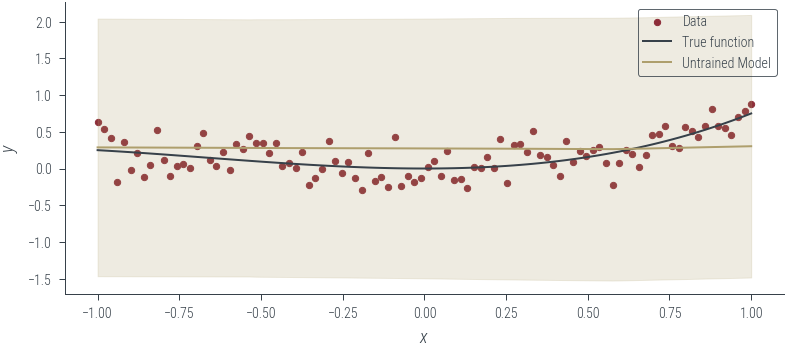

In [240]:
def plot_heteroskedastic_model(model, l="Untrained model", log_noise_param=fixed_log_noise_std):

    with torch.no_grad():
        y_hat, log_noise_std = model(x_lin[:, None])
        std = torch.exp(log_noise_std).cpu()
        y_hat = y_hat.cpu()
    
    _plot(y_hat, std, l)


plot_heteroskedastic_model(model_3, "Untrained Model")


In [243]:
# Train
params = list(model_3.parameters())

def loss_heteroskedastic(model, x, y):
    mu_hat, log_noise_std = model(x)
    noise_std = torch.exp(log_noise_std)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).mean()

def train_heteroskedastic(model, loss_func, params, x, y, n_epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(params, lr=lr)
    for epoch in range(n_epochs):
        # Print every 10 epochs
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: loss {loss_func(model, x, y)}')
        optimizer.zero_grad()
        loss = loss_func(model, x, y)
        loss.backward()
        optimizer.step()
    return loss.item()

train_heteroskedastic(model_3, loss_heteroskedastic, params, x_lin[:, None], y, n_epochs=1000, lr=0.001)

Epoch 0: loss 0.8471216559410095
Epoch 50: loss 0.5730974674224854
Epoch 100: loss 0.21664416790008545
Epoch 150: loss -0.0901612937450409
Epoch 200: loss -0.18870659172534943
Epoch 250: loss -0.21993499994277954
Epoch 300: loss -0.23635315895080566
Epoch 350: loss -0.24628539383411407
Epoch 400: loss -0.2610110640525818
Epoch 450: loss -0.2744489908218384
Epoch 500: loss -0.28417855501174927
Epoch 550: loss -0.29257726669311523
Epoch 600: loss -0.30057546496391296
Epoch 650: loss -0.3061988353729248
Epoch 700: loss -0.31035324931144714
Epoch 750: loss -0.3138866126537323
Epoch 800: loss -0.3167155683040619
Epoch 850: loss -0.3188284635543823
Epoch 900: loss -0.32069918513298035
Epoch 950: loss -0.32232046127319336


-0.323951780796051

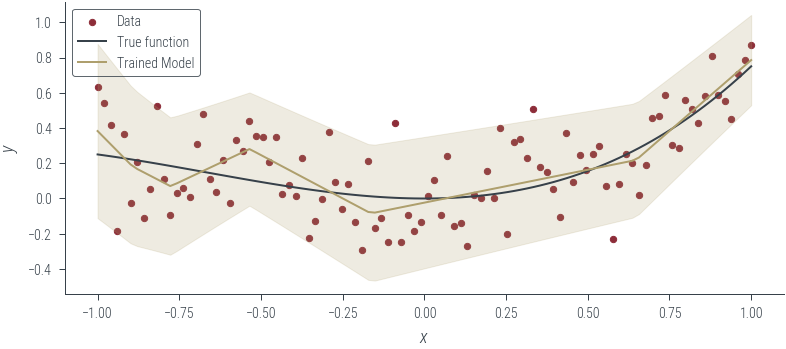

In [244]:
# Plot the trained model
plot_heteroskedastic_model(model_3, "Trained Model")

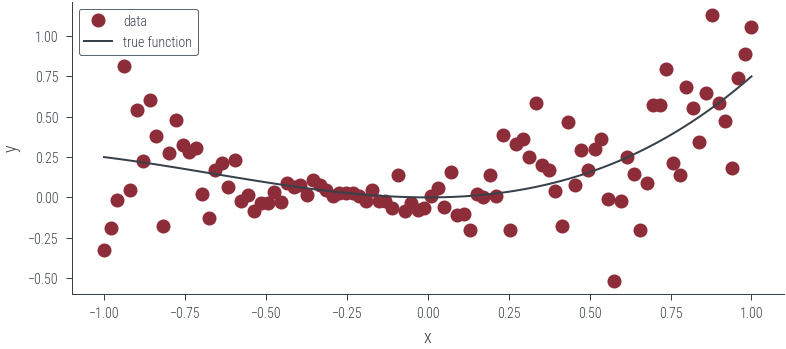

In [249]:
# Now, let us try these on some data that is not homoskedastic

# Generate data

torch.manual_seed(42)
N = 100
x_lin = torch.linspace(-1, 1, N)

f = lambda x: 0.5 * x**2 + 0.25 * x**3

eps = torch.randn(N) * (0.1 + 0.4 * x_lin)

y = f(x_lin) + eps

# Move to GPU
x_lin = x_lin.to(device)
y = y.to(device)

# Plot data and true function
plt.plot(x_lin.cpu(), y.cpu(), 'o', label='data')
plt.plot(x_lin.cpu(), f(x_lin).cpu(), label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()